# Introduction

Simple downloader for historical data

We are going to use https://bitinfocharts.com for now

In [37]:
import re
import datetime as dt
import urllib.request
from typing import List

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_website_as_string(url):
    hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
    req = urllib.request.Request(url, headers=hdr)
    response = urllib.request.urlopen(req)
    content_raw = response.read()
    content = content_raw.decode()
    
    return content   # HTML with embedded script source code

In [19]:
url = 'https://bitinfocharts.com/comparison/ethereum-mining_profitability.html'

In [20]:
content = get_website_as_string(url)

In [55]:
df

,profitability,price,income
2019-01-01,0.0148,136.343,2.017876
2019-01-02,0.0161,149.513,2.407159
2019-01-03,0.0153,152.232,2.329150
2019-01-04,0.0154,152.948,2.355399
2019-01-05,0.0159,159.119,2.529992
...,...,...,...
2020-12-27,0.0486,662.017,32.174026
2020-12-28,0.0543,724.664,39.349255
2020-12-29,0.0509,719.423,36.618631
2020-12-30,0.0573,735.948,42.169820


In [21]:
def _parse_datapoint(datapoint_str, p_date, p_float):
    """Parse datapoint string in format '[new Date("2015/07/30"),9.355]' """
    
    date_part, float_part = datapoint_str.strip('[]').split(',')
    
    date_matches = p_date.findall(date_part)
    assert len(date_matches) == 1
    date_str = date_matches[0]
    date_dt = dt.datetime.strptime(date_str, '%Y/%m/%d')
    
#     float_matches = p_float.findall(datapoint_str)
#     print(float_matches)
#     assert len(float_matches) == 1
#     float_str = float_matches[0]
    float_f = float(float_part)
    
    return date_dt, float_f

In [22]:
def extract_data_from_website(content: str, column_name: str):
    p_datapoint = re.compile('\[new Date\("\d+\/\d+\/\d+"\),\d+(?:\.\d+)?\]')
    p_date = re.compile('\d+\/\d+\/\d+')
    p_float = re.compile('\d+(?:\.\d+)?')
    
    list_of_matches: List[str] = p_datapoint.findall(content)
        
    dates_list = []
    values_list = []
    for datapoint_str in list_of_matches:
        date, value = _parse_datapoint(datapoint_str, p_date, p_float)
        dates_list.append(date)
        values_list.append(value)
    
    return pd.Series(data=values_list, index=dates_list, name=column_name)

In [23]:
series_mining_profitability = extract_data_from_website(content, column_name='profitability')

In [24]:
url = 'https://bitinfocharts.com/comparison/ethereum-price.html'

In [25]:
content = get_website_as_string(url)

In [26]:
series_price = extract_data_from_website(content, column_name='price')

In [46]:
df = pd.concat([series_mining_profitability, series_price], axis=1)

In [47]:
df.dropna(inplace=True)

In [48]:
df['income'] = df.profitability * df.price

In [49]:
df = df[df.index >= dt.datetime(2019, 1, 1)]

In [50]:
df = df[df.index <= dt.datetime(2020, 12, 31)]

In [51]:
df

,profitability,price,income
2019-01-01,0.0148,136.343,2.017876
2019-01-02,0.0161,149.513,2.407159
2019-01-03,0.0153,152.232,2.329150
2019-01-04,0.0154,152.948,2.355399
2019-01-05,0.0159,159.119,2.529992
...,...,...,...
2020-12-27,0.0486,662.017,32.174026
2020-12-28,0.0543,724.664,39.349255
2020-12-29,0.0509,719.423,36.618631
2020-12-30,0.0573,735.948,42.169820


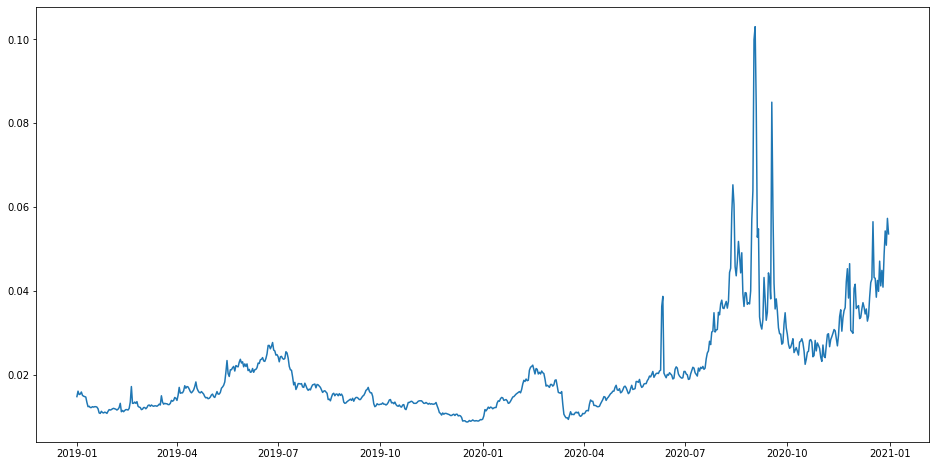

In [57]:
_, ax = plt.subplots(figsize=(16,8))
ax.plot(df.index, df.profitability*)
plt.show()

In [61]:
df['profitability_20'] = df.profitability * 20 * 2

In [62]:
df

,profitability,price,income,profitability_20
2019-01-01,0.0148,136.343,2.017876,0.592
2019-01-02,0.0161,149.513,2.407159,0.644
2019-01-03,0.0153,152.232,2.329150,0.612
2019-01-04,0.0154,152.948,2.355399,0.616
2019-01-05,0.0159,159.119,2.529992,0.636
...,...,...,...,...
2020-12-27,0.0486,662.017,32.174026,1.944
2020-12-28,0.0543,724.664,39.349255,2.172
2020-12-29,0.0509,719.423,36.618631,2.036
2020-12-30,0.0573,735.948,42.169820,2.292


In [63]:
df.profitability_20.sum()

600.0992

In [72]:
df['cost_per_day'] = [0.432]*len(df)

In [74]:
df.cost_per_day.sum()

315.7920000000001

In [75]:
600-315

285

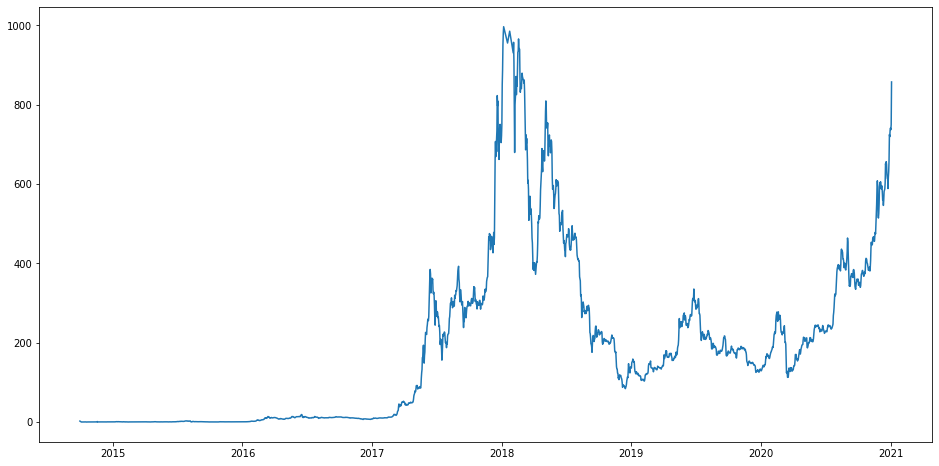

In [26]:
_, ax = plt.subplots(figsize=(16,8))
ax.plot(series_price.index, series_price)
plt.show()

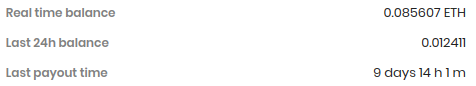

In [65]:
hours = 9*24 + 14
hours

230

In [66]:
days = hours / 24
days

9.583333333333334

In [67]:
eth_mined = 0.085

In [68]:
eth_per_day = eth_mined / days
eth_per_day

0.008869565217391304

In [69]:
dollar_per_day = eth_per_day * 1700
dollar_per_day

15.078260869565216

In [70]:
dollar_per_day / 150 * 20

2.0104347826086952